In [1]:
# %pip install matplotlib
# %pip install scipy
# %pip install pandas
# %pip install lifelines matplotlib
# %pip install numpy
# %pip install seaborn

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy import stats
from io import StringIO
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import numpy as np
import re
import seaborn as sns
from scipy.stats import ttest_ind

# Get all the files in the directory
all_files = glob.glob("./csv/*.csv")

df_dict = {}

for filename in all_files:
    df_name = os.path.basename(filename).split(".")[0]  
    df_dict[df_name] = pd.read_csv(filename)

# for name, df in df_dict.items():
#     print(f"DataFrame: {name}")

df_conformant_log_hierarchical = df_dict['conformant_log_hierarchical']
df_non_conformant_log_hierarchical = df_dict['non_conformant_log_hierarchical']
# print(df_conformant_log_hierarchical.head())
# df_fitting_log_and = df_dict['fitting_log_and']
# print(df_fitting_log_and.head())
# print(df_non_conformant_log_hierarchical.head())
# df_non_fitting_log_and = df_dict['non_fitting_log_and']
# print(df_non_fitting_log_and.head())

In [3]:
def process_student_times(df_log):
    start_times = df_log[df_log['Activity'] == 'Start'][['Case ID', 'Complete Timestamp']]
    end_times = df_log[df_log['Activity'] == 'End'][['Case ID', 'Complete Timestamp']]

    start_times = start_times.rename(columns={'Complete Timestamp': 'Start'})
    end_times = end_times.rename(columns={'Complete Timestamp': 'End'})

    student_times = pd.merge(start_times, end_times, on='Case ID', how='inner')

    student_times['Start'] = pd.to_datetime(student_times['Start'])
    student_times['End'] = pd.to_datetime(student_times['End'])

    student_times['Duration'] = student_times['End'] - student_times['Start']

    student_times['Duration(month)'] = student_times['Duration'].dt.days / 30

    program_mapping = (
        df_log[['Case ID', 'Program']]
        .drop_duplicates()
        .groupby('Case ID')['Program']
        .apply(lambda x: '; '.join(x.unique()))
        .reset_index()
    )

    student_times = pd.merge(student_times, program_mapping, on='Case ID', how='left')

    student_times['Program'] = student_times['Program'].apply(lambda x: '; '.join([p for p in x.split('; ') if 'Start' not in p and 'End' not in p]))

    return student_times

conformant_student_times = process_student_times(df_conformant_log_hierarchical)
non_conformant_student_times = process_student_times(df_non_conformant_log_hierarchical)

# Study Duration Analysis and Comparison

We aim to understand the differences in study duration between students who meet and do not meet prerequisite course requirements.

## 1. Comparison of Average Study Duration

In [4]:
# 计算平均学习时间（从开始到目前的时间）
conformant_avg_time = conformant_student_times['Duration(month)'].mean()
non_conformant_avg_time = non_conformant_student_times['Duration(month)'].mean()

# 打印结果
print(f'Average study duration for students who meet prerequisite course requirements: {conformant_avg_time:.2f} months')
print(f'Average study duration for students who do not meet prerequisite course requirements: {non_conformant_avg_time:.2f} months')

Average study duration for students who meet prerequisite course requirements: 9.39 months
Average study duration for students who do not meet prerequisite course requirements: 26.43 months


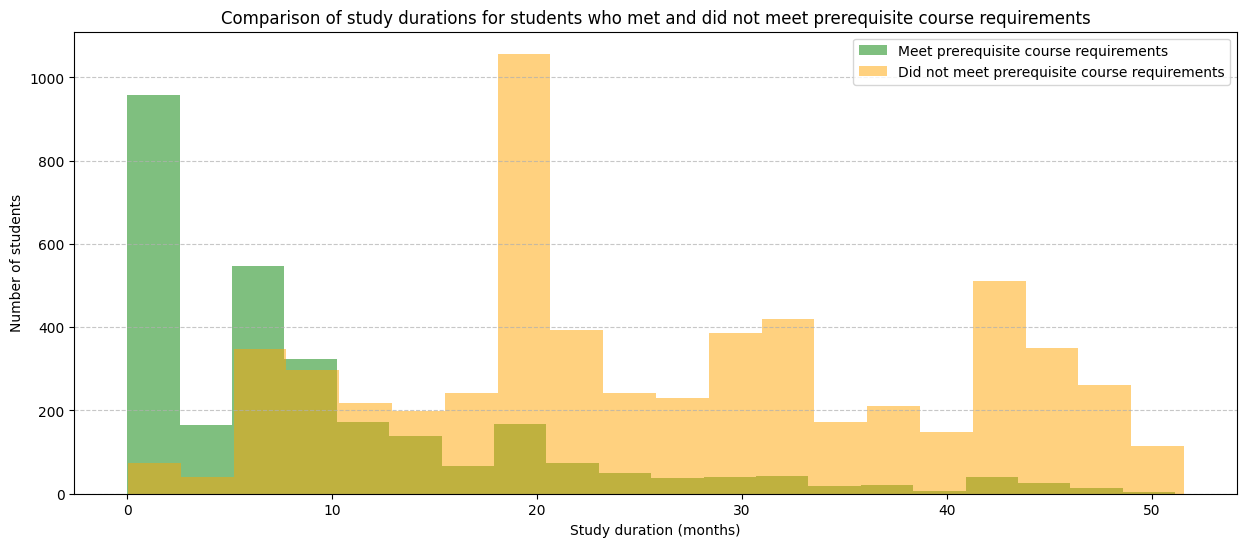

In [5]:
plt.figure(figsize=(15, 6))

# 绘制直方图对比学习时间
plt.hist(conformant_student_times['Duration(month)'], bins=20, alpha=0.5, label='Meet prerequisite course requirements', color='green')
plt.hist(non_conformant_student_times['Duration(month)'], bins=20, alpha=0.5, label='Did not meet prerequisite course requirements', color='orange')

# 添加标题和标签
plt.xlabel('Study duration (months)')
plt.ylabel('Number of students')
plt.title('Comparison of study durations for students who met and did not meet prerequisite course requirements')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

We visualized the distribution of study durations for students who met and did not meet the prerequisite course requirements using a histogram. In the chart, the green bars represent students who met the requirements, while the orange bars represent those who did not. It can be observed that students who met the requirements are concentrated in shorter study durations, while those who did not meet the requirements have a broader distribution towards longer study durations. This further supports the importance of prerequisite courses, indicating that students who meet these requirements are more likely to maintain shorter study timelines.

## 2. Student Count by Study Duration Segments

To gain a more detailed understanding of student distribution across different time segments, we divided the study duration into several intervals (each covering 12 months) and counted the number of students in each interval. The specific results are as follows:

In [6]:
# 分组统计学习时间段内的学生人数
bins = [0, 12, 24, 36, 48, 60]  # 以每12个月为一个时间段
labels = ['0-12 month', '12-24 month', '24-36 month', '36-48 month', '48-60 month']

conformant_grouped = pd.cut(conformant_student_times['Duration(month)'], bins=bins, labels=labels).value_counts().sort_index()
non_conformant_grouped = pd.cut(non_conformant_student_times['Duration(month)'], bins=bins, labels=labels).value_counts().sort_index()

# 打印不同时间段的学生人数
print("Study duration by students who met the prerequisite course requirements at various times:")
print(conformant_grouped)

print("\nStudy duration of students who did not meet prerequisite course requirements across time:")
print(non_conformant_grouped)

Study duration by students who met the prerequisite course requirements at various times:
Duration(month)
0-12 month     1477
12-24 month     530
24-36 month     170
36-48 month     104
48-60 month       8
Name: count, dtype: int64

Study duration of students who did not meet prerequisite course requirements across time:
Duration(month)
0-12 month      888
12-24 month    2031
24-36 month    1398
36-48 month    1373
48-60 month     230
Name: count, dtype: int64


From the results, it can be seen that students who met the prerequisite requirements are mainly concentrated in the shorter study duration intervals, while those who did not meet the requirements tend to be in the longer study duration intervals. This indicates that well-designed and effectively implemented prerequisite courses play an important role in promoting students' study progress.

# Analyzing the Impact of Education Paths (Programs) on Students' Completion Time

We aim to understand how educational backgrounds (e.g., majors, education paths) influence the time students take to complete their studies after meeting prerequisite course requirements. Specifically, we want to answer the following questions:

- Are students from different education paths more likely to meet prerequisite course requirements?
- Is there a significant difference in the average time to complete studies between students who meet prerequisite requirements and those who do not?
- Are there certain education paths with more reasonable prerequisite arrangements that help students complete their studies faster?

In [7]:
# 添加标识列，表示是否遵循先修课程
conformant_student_times['Conformant'] = 1
non_conformant_student_times['Conformant'] = 0

# 合并两个数据集
data = pd.concat([conformant_student_times, non_conformant_student_times], ignore_index=True)

## 1. Average Education Duration Analysis

By grouping students by "Education Level" and "Conformant," we calculated the average time to complete their studies for students with different educational backgrounds, both for those who meet prerequisite requirements and those who do not.

In [8]:
df = pd.DataFrame(data)

# 初始化一个集合来存储所有学位类型
degree_types = set()

# 提取每个专业和学位类型
for program_list in df['Program']:
    # 拆分多个条目
    programs = program_list.split('; ')
    for prog in programs:
        # 使用正则表达式找到最后一个逗号后的学位类型，保证只提取学位信息
        match = re.search(r',\s*([^,]+)$', prog.strip())
        if match:
            degree_type = match.group(1)
            degree_types.add(degree_type)

# 打印所有发现的学位类型
print("数据集中发现的学位类型:")
for degree in degree_types:
    print(degree)

数据集中发现的学位类型:
bach.
ing.prof.bach.
cand.polyt.
ing.bach.
ingeniør bach.
cand.tech.


In [9]:
# 定义学位类型归类规则
degree_classification = {
    'bach.': 'Undergraduate',
    'ingeniør bach.': 'Undergraduate',
    'ing.bach.': 'Undergraduate',
    'ing.prof.bach.': 'Undergraduate',
    'cand.tech.': 'Graduate',
    'cand.polyt.': 'Graduate'
}

# 添加新列：本科专业、硕士专业
df['Undergraduate Program'] = ''
df['Graduate Program'] = ''

# 遍历数据并归类学位类型
for index, row in df.iterrows():
    programs = row['Program'].split('; ')
    for prog in programs:
        match = re.search(r',\s*([^,]+)$', prog.strip())
        if match:
            degree_type = match.group(1)
            
            degree_category = degree_classification.get(degree_type.lower(), 'Other')
            if degree_category == 'Undergraduate':
                df.at[index, 'Undergraduate Program'] += prog + '; '
            elif degree_category == 'Graduate':
                df.at[index, 'Graduate Program'] += prog + '; '

df['Undergraduate Program'] = df['Undergraduate Program'].str.rstrip('; ')
df['Graduate Program'] = df['Graduate Program'].str.rstrip('; ')

# Replace empty strings with NaN
df = df.replace({'Undergraduate Program': {'': np.nan}, 'Graduate Program': {'': np.nan}})

In [10]:
# 添加新列表示教育类型
def classify_education(row):
    if pd.notna(row['Undergraduate Program']) and pd.isna(row['Graduate Program']):
        return 'Only Undergraduate'
    elif pd.isna(row['Undergraduate Program']) and pd.notna(row['Graduate Program']):
        return 'Only Graduate'
    elif pd.notna(row['Undergraduate Program']) and pd.notna(row['Graduate Program']):
        return 'Undergraduate and Graduate'
    else:
        return 'Other'

df['Education Level'] = df.apply(classify_education, axis=1)

# 检查每个分类的学生数量
print(df['Education Level'].value_counts())

Education Level
Only Graduate                 3681
Only Undergraduate            3609
Undergraduate and Graduate    1542
Name: count, dtype: int64


In [11]:
# 分组计算平均教育时间
avg_duration_by_level = df.groupby(['Education Level', 'Conformant'])['Duration(month)'].mean().reset_index()

print("平均教育时间（按教育背景和是否满足先修课程要求分类）:")
print(avg_duration_by_level)

平均教育时间（按教育背景和是否满足先修课程要求分类）:
              Education Level  Conformant  Duration(month)
0               Only Graduate           0        18.064278
1               Only Graduate           1         7.880635
2          Only Undergraduate           0        25.216774
3          Only Undergraduate           1         8.951458
4  Undergraduate and Graduate           0        40.852751
5  Undergraduate and Graduate           1        38.006000


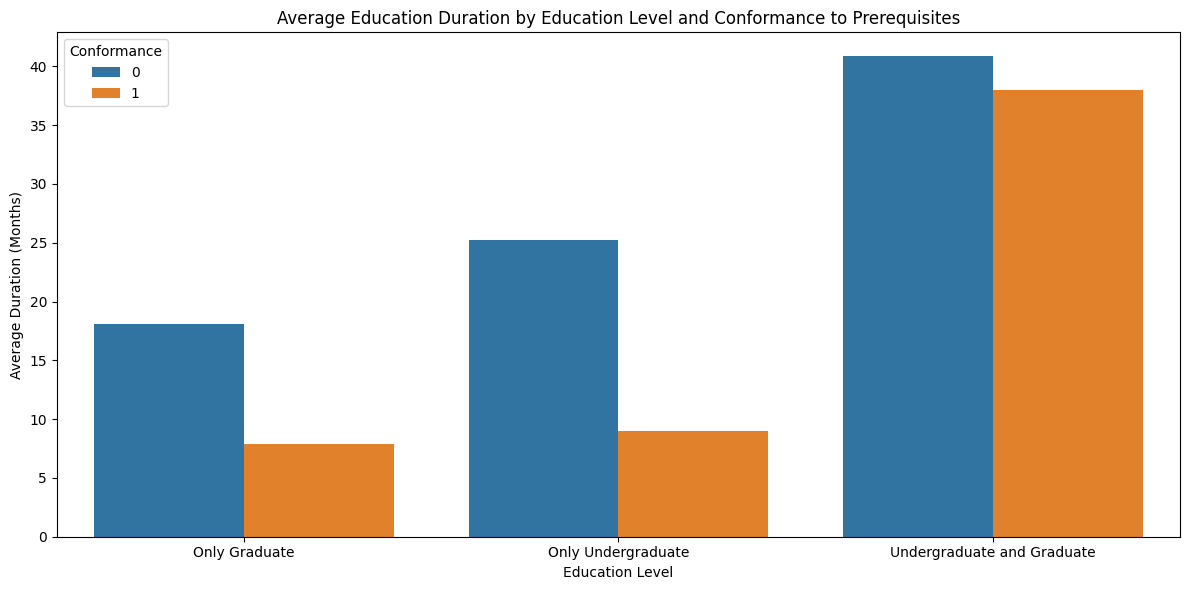

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_duration_by_level, x='Education Level', y='Duration(month)', hue='Conformant')
plt.xlabel('Education Level')
plt.ylabel('Average Duration (Months)')
plt.title('Average Education Duration by Education Level and Conformance to Prerequisites')
plt.legend(title='Conformance')
plt.tight_layout()
plt.show()

The visualized data shows that there is a significant difference in the average education duration depending on whether students meet the prerequisite requirements. For example, students who meet prerequisite requirements tend to complete their studies faster, especially in the groups of students who only pursued undergraduate or only pursued graduate studies.

## 2. In-depth Analysis of Education Paths

To better understand how education paths affect the time required to complete studies, we created an "Education Path" column to describe each student's education path (e.g., "Undergraduate Program -> Graduate Program"). We then selected the top 10 most common education paths and calculated the average education duration for students who met and did not meet the prerequisite requirements.

In [13]:
df['Education Path'] = df.apply(
    lambda row: f"{row['Undergraduate Program']} -> {row['Graduate Program']}" if pd.notna(row['Undergraduate Program']) and pd.notna(row['Graduate Program']) else
                (row['Undergraduate Program'] if pd.notna(row['Undergraduate Program']) else
                 row['Graduate Program'] if pd.notna(row['Graduate Program']) else 'No Education Info'),
    axis=1
)

top_n_paths = df['Education Path'].value_counts().nlargest(10).index

df_top_paths = df[df['Education Path'].isin(top_n_paths)]

avg_duration_by_path_conformance = df_top_paths.groupby(['Education Path', 'Conformant'])['Duration(month)'].mean().reset_index()

print("\nAverage Education Duration for Top 10 Education Paths by Prerequisite Conformance:")
avg_duration_by_path_conformance.head(20)



Average Education Duration for Top 10 Education Paths by Prerequisite Conformance:


,Education Path,Conformant,Duration(month)
0,"Byggeri og infrastruktur, ing.prof.bach.",0,26.057939
1,"Byggeri og infrastruktur, ing.prof.bach.",1,4.183333
2,"Byggeteknologi, cand.polyt.",0,17.617391
3,"Byggeteknologi, cand.polyt.",1,3.217695
4,"Bæredygtig energi, cand.polyt.",0,17.392708
5,"Bæredygtig energi, cand.polyt.",1,4.194086
6,"Design og innovation, cand.polyt.",0,19.433333
7,"Design og innovation, cand.polyt.",1,4.731771
8,"Elektroteknologi, cand.polyt.",0,19.071975
9,"Elektroteknologi, cand.polyt.",1,7.922043


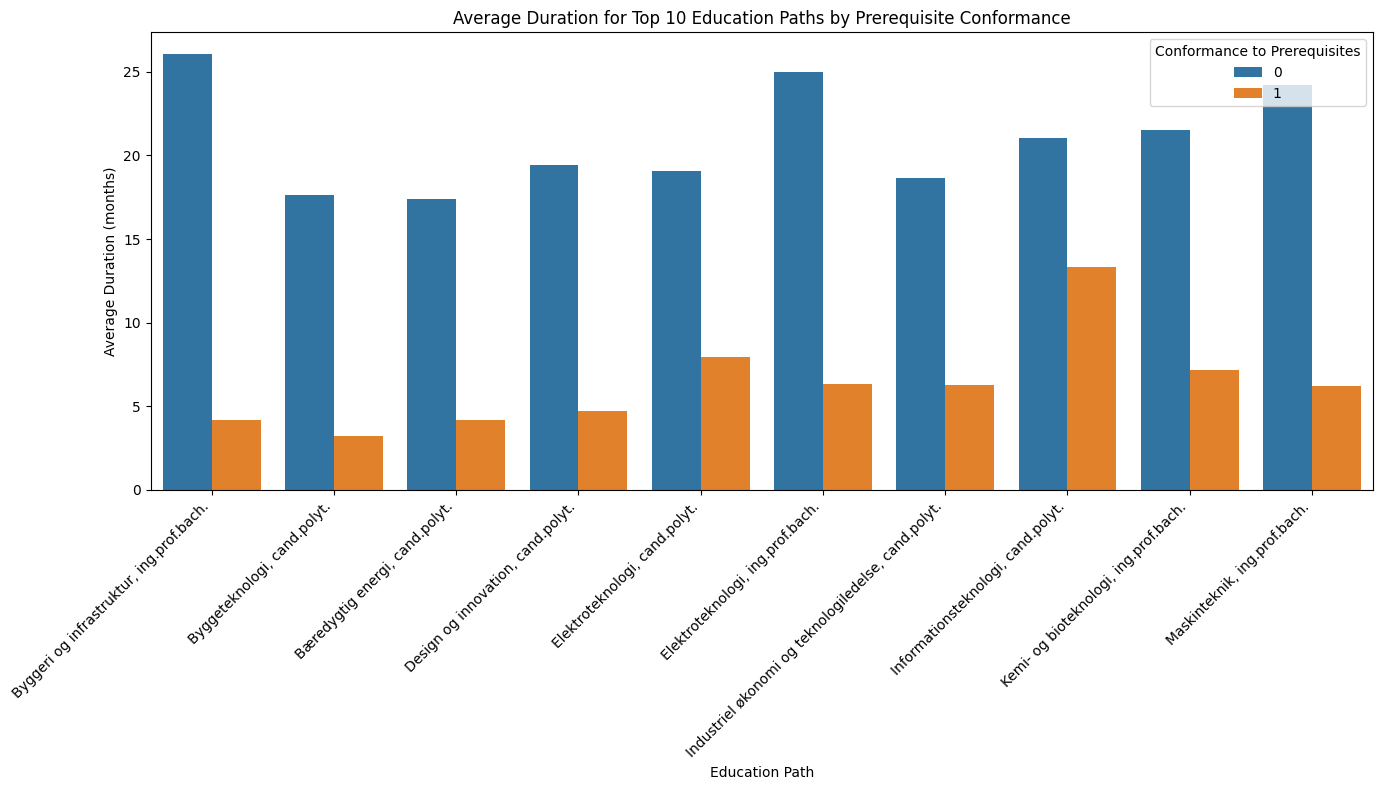

In [14]:
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_duration_by_path_conformance, x='Education Path', y='Duration(month)', hue='Conformant')
plt.xlabel('Education Path')
plt.ylabel('Average Duration (months)')
plt.title('Average Duration for Top 10 Education Paths by Prerequisite Conformance')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Conformance to Prerequisites')
plt.tight_layout()
plt.show()


By visualizing the results for these paths, we can more clearly see the conformance and average completion time for different paths. For most education paths, students who met the prerequisite requirements significantly reduced the time required to complete their studies. This indicates that the prerequisite requirements for these paths are well aligned with students' knowledge backgrounds and learning progress, making the course design relatively reasonable.

# Conformance Rate for the Top 20 Education Paths（Programs）

We aim to understand how well students meet prerequisite course requirements across different education paths (majors). For example:

- Which education paths have students who are more likely to meet the prerequisite requirements?
- Are there significant differences between different education paths? Are some paths particularly easy or difficult for students to meet the requirements?

The answers to these questions can help us evaluate whether the design of certain education paths is reasonable, or if adjustments are needed for the prerequisite requirements. 

To achieve this, we calculated the conformance rate for the top 20 most common education paths. The conformance rate in this context refers to the proportion of students who meet the prerequisite course requirements within a specific education path. It is calculated by dividing the number of students who meet the prerequisites by the total number of students in that path. For example, if there are 100 students in a particular education path, and 80 of them meet the prerequisite requirements, the conformance rate for that path would be 80%.

By focusing only on the most common paths, we can better summarize and analyze the main trends.

In [15]:
top_20_paths = df['Education Path'].value_counts().nlargest(20).index

df_top_paths = df[df['Education Path'].isin(top_20_paths)]

conformance_rate_top_paths = df_top_paths.groupby('Education Path')['Conformant'].mean().reset_index()
conformance_rate_top_paths = conformance_rate_top_paths.sort_values(by='Conformant', ascending=False).reset_index(drop=True).rename(columns={'Conformant': 'Conformance Rate'})

print("\nConformance Rate for the Top 20 Education Paths:")
print(conformance_rate_top_paths)


Conformance Rate for the Top 20 Education Paths:
                                       Education Path  Conformance Rate
0                  Informationsteknologi, cand.polyt.          0.990099
1    Matematisk modellering og computing, cand.polyt.          0.664336
2                   Softwareteknologi, ing.prof.bach.          0.562500
3                           Bioteknologi, cand.polyt.          0.448529
4                       Elektroteknologi, cand.polyt.          0.441281
5                Konstruktion og mekanik, cand.polyt.          0.427632
6                         Bygningsdesign, cand.polyt.          0.395522
7                         Miljøteknologi, cand.polyt.          0.386503
8                Eksport og teknologi, ing.prof.bach.          0.379518
9                   Design og innovation, cand.polyt.          0.367816
10                   Elektroteknologi, ing.prof.bach.          0.336898
11                       Maskinteknik, ing.prof.bach.          0.326848
12  Industriel

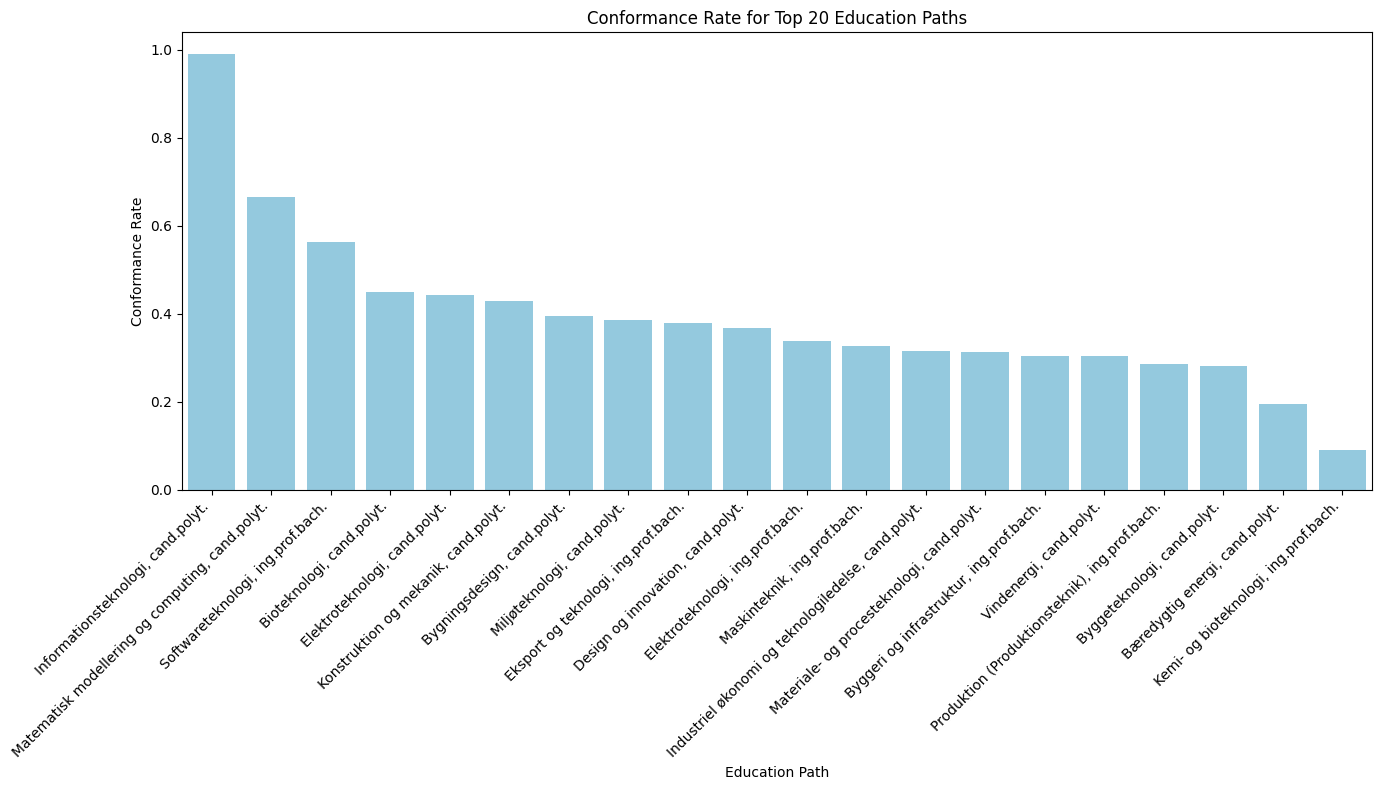

In [16]:
plt.figure(figsize=(14, 8))
sns.barplot(data=conformance_rate_top_paths, x='Education Path', y='Conformance Rate', color='skyblue')
plt.xlabel('Education Path')
plt.ylabel('Conformance Rate')
plt.title('Conformance Rate for Top 20 Education Paths')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conformance Rates and Education Paths (Programs)

1. **High Conformance Rate Education Paths**:

- Informationsteknologi, cand.polyt. (99.01%)
- Matematisk modellering og computing, cand.polyt. (66.43%)

These education paths have a high conformance rate, indicating that the course design aligns well with students' prior knowledge and skills. The prerequisite requirements are relatively reasonable and easy to understand, allowing students to successfully complete them.

2. **Low Conformance Rate Education Paths**:

- Kemi- og bioteknologi, ing.prof.bach. (8.93%)
- Bæredygtig energi, cand.polyt. (19.50%)

For education paths with a low conformance rate, further investigation may be needed to determine:
- Are the prerequisite requirements too challenging or not clearly communicated?
- Do students need more support, such as preparatory courses or tutoring resources, to help them meet these requirements?
